In [1]:
#HOUSE CLEAN idea credit: https://www.r-bloggers.com/kaggles-advanced-regression-competition-predicting-housing-prices-in-ames-iowa/
#"Premature optimization is the root of all evil.." -Donald Knuth
import pandas as pd
import pandas_profiling as pf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.options.display.max_rows=150
pd.options.display.max_columns=200

In [2]:
#Fetch data
train=pd.read_csv('data/train.csv')  
test=pd.read_csv('data/test.csv')

In [3]:
from scipy import stats
from scipy.stats import norm

def repl_NaN_w_mode(df):
#Builds nested dictionary 'd'.  
    d={}                   #initialize OUTER dict 'd' outside loop
    for c in df.columns:
        d[c]={}            #initialize INNER dict 'c' inside loop
        c_mode=df[c].mode()[0]  #exclude junk after mode   
        d[c][np.nan]=c_mode
        df=df.replace(d)
    return df

def repl_NaN_w_text(df, mytext):
#Builds nested dictionary 'd'.  
    d={}                   #initialize OUTER dict 'd' outside loop
    for c in df.columns:
        d[c]={}            #initialize INNER dict 'c' inside loop
        d[c][np.nan]=mytext
        df=df.replace(d)
    return df

def normalize_feature(df, bad_feature):

    #Make histogram & normal probability plot
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
    ax1.set_title(bad_feature+' Histogram - Not Normal Distribution')
    res=stats.probplot(df[bad_feature], plot=ax2)
    ax2.set_title('Nonlinear Probability Plot')

    #Normalize with log (x+1).  Log of skewed feature: log e(feature+1)=normFeat
    #Exponential equation to undo normpr: e^normFeat-1=feature
    log_feat=np.log(df[bad_feature]+1)
    
    #Plots after normalization
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(log_feat, color='g', fit=norm, ax=ax1)
    ax1.set_title(bad_feature+' Histogram - Normal Distribution')
    res=stats.probplot(log_feat, plot=ax2)
    ax2.set_title('Linear Probability Plot')
    return log_feat

def KBest_drop_numeric(df, drop_frac):
    #select numerical data type and assign X, y
    num_df=df.select_dtypes(include=['int64','float64'])  #omitting  dummies uint8
    X=num_df.copy()  #create df copy to avoid Warning
    X.drop(['SalePrice'], axis=1, inplace=True)
    y=num_df['SalePrice']
    
    #Univariate feature selection
    sel=SelectKBest(score_func=f_regression,k='all')  #f_regression is scoring funct. how good is a feature in model?
    sel.fit(X,y)
    feat_scores=list(zip(df.columns, sel.scores_))
    feat_scores.sort(key=itemgetter(1))  # reverse sort - reverse=True
    drop_features=[]
    drop_count=int(drop_frac*len(feat_scores))
    for row in feat_scores:
        drop_features.append(row[0])
    drop_features=drop_features[0:drop_count]
    print('Before KBest low score feature drop:', df.shape,'...')
    
    return drop_features

def features_unique_to_set(train, test):
    tr=set(train.columns)
    te=set(test.columns)
    unique_to_tr=tr-te
    #unique_to_tr.remove(target_variable)   #exclude target variable (SalesPrice) from comparison
    unique_to_te=te-tr
    return unique_to_tr, unique_to_te

C:\Users\Justin\Anaconda3\envs\virtbox\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


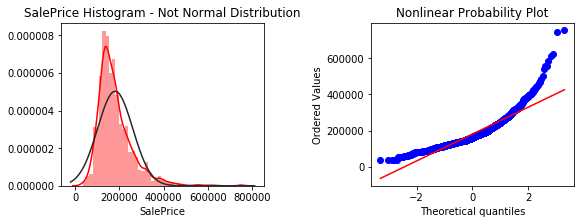

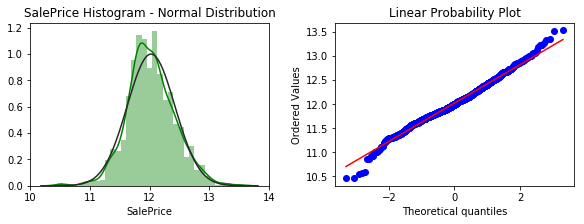

In [4]:
#SalesPrice is only in train df
logSP=normalize_feature(df=train, bad_feature='SalePrice')
train['SalePrice']=logSP

In [5]:
#COMBINE train/test for cleaning.  A data issue can be unique to one csv, like a different class type for a feature.
#train Id: 1-1460.  test Id: 1461-2919.
comb=train.append(test, ignore_index=True, sort=False).copy()  #Id identifies the observation rows
print('Orig comb shape:', comb.shape)

Orig comb shape: (2919, 81)


In [6]:
#Issue 1: Get PoolQC NaNs with nonzero PoolArea.
comb[(comb['PoolQC'].isnull()) & (comb['PoolArea']>0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2420,2421,20,RL,75.0,9532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,595.0,Rec,354.0,156.0,1105.0,GasA,Gd,Y,SBrkr,1647,0,0,1647,1.0,0.0,1,0,3,1,TA,6,Min1,1,Fa,Attchd,1953.0,Fin,1.0,280.0,TA,TA,Y,225,0,0,0,0,368,NaN,GdPrv,NaN,0,2,2007,WD,Normal,NaN
2503,2504,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.0,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal,NaN
2599,2600,20,RL,200.0,43500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,3,5,1953,1953,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,2034,0,0,2034,0.0,0.0,1,0,2,1,TA,9,Min1,0,NaN,2Types,1953.0,RFn,4.0,1041.0,TA,TA,N,483,266,0,0,0,561,NaN,GdPrv,NaN,0,6,2007,WD,Normal,NaN


In [7]:
#Fix issue 1 with mode='Gd'.  
comb.loc[[2420,2503,2599], 'PoolQC']=['Gd','Gd','Gd']
#PoolQC=NaN must be class 'None'
comb.replace({'PoolQC':{np.nan:'None'}}, inplace=True)

In [8]:
#Scrub nan LotFrontage.  Replace nan with Neigborhood median, Ex. Blmngtn median.  Median per train ONLY.

def get_class_stat(df, agg_col, agg_class, target_col):
    filtered=train[train[agg_col]==agg_class]
    return filtered[target_col].median()

def scrub_frontage(row):
    if np.isnan(row['LotFrontage'])==True:
        median=get_class_stat(df=train,agg_col='Neighborhood', agg_class=row['Neighborhood'], target_col='LotFrontage')
        return median
    else:
        return row['LotFrontage']
comb['LotFrontage']=comb.apply(scrub_frontage, axis=1)  #apply function to row

#dump GarageYrBlt - too many nans and redundant
comb.drop(['GarageYrBlt'], axis=1, inplace=True, errors='ignore')

In [9]:
#Replace feature nans.  MSZoning fixed separately.
nan_dict={
            'Alley' : {np.nan : 'None'},
            'BsmtCond' : {np.nan : 'None'},
            'BsmtExposure' : {np.nan : 'None'},
            'BsmtFinSF1' : {np.nan : 0},
            'BsmtFinSF2' : {np.nan : 0},
            'BsmtFinType1' : {np.nan : 'None'},
            'BsmtFinType2' : {np.nan : 'None'},
            'BsmtFullBath' : {np.nan : 0},
            'BsmtHalfBath' : {np.nan : 0},
            'BsmtQual' : {np.nan : 'None'},
            'BsmtUnfSF' : {np.nan : 0},
            'Electrical' : {np.nan : 'SBrkr'},
            'Exterior1st' : {np.nan : 'VinylSd'},
            'Exterior2nd' : {np.nan : 'VinylSd'},
            'Fence' : {np.nan : 'None'},
            'FireplaceQu' : {np.nan : 'None'},
            'Functional' : {np.nan : 'Typ'},
            'GarageArea' : {np.nan : 0},
            'GarageCars' : {np.nan : 2},
            'GarageCond' : {np.nan : 'None'},
            'GarageFinish' : {np.nan : 'None'},
            'GarageQual' : {np.nan : 'None'},
            'GarageType' : {np.nan : 'None'},
            'KitchenQual' : {np.nan : 'TA'},
            'MasVnrArea' : {np.nan : 0},
            'MasVnrType' : {np.nan : 'None'},
            'MiscFeature' : {np.nan : 'None'},
            'PoolQC' : {np.nan : 'None'},
            'SaleType' : {np.nan : 'WD'},
            'TotalBsmtSF' : {np.nan : 0},
            'Utilities' : {np.nan : 'AllPub'}
        }

comb.replace(nan_dict, inplace=True)

In [10]:
#Fix attributes for garage that exists (360 sq ft)
comb.loc[[2126], 'GarageFinish']=['Unf']
comb.loc[[2126], 'GarageQual']=['TA']
comb.loc[[2126], 'GarageCond']=['TA']
comb.loc[[2126]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2126,2127,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,None,Detchd,Unf,1.0,360.0,TA,TA,Y,64,0,180,0,0,0,None,MnPrv,Shed,1000,9,2008,WD,Normal,NaN


In [11]:
#Fix nan MSZoning
comb.loc[[1915,2216,2250],['MSZoning']]=['RM','RM','RM']
comb.loc[[2904],['MSZoning']]=['RL']
comb.loc[[1915,2216,2250,2904]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,RM,109.0,21780,Grvl,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal,NaN
2216,2217,20,RM,80.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Typ,0,None,Attchd,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml,NaN
2250,2251,70,RM,60.0,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal,NaN
2904,2905,20,RL,125.0,31250,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,None,Attchd,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,None,None,None,0,5,2006,WD,Normal,NaN


In [12]:
ord_coding={
        'ExterQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'BsmtCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'BsmtQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'ExterCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'HeatingQC' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'KitchenQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'GarageQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'GarageCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'LandContour' : {'Lvl': 0, 'Bnk': 1, 'HLS':2, 'Low': -1},
        'BsmtFinType1' : {'GLQ': 3, 'ALQ': 2, 'BLQ':1, 'Rec':2, 'LwQ ':1,"Unf":1, "None": 0},
        'BsmtFinType2' : {'GLQ': 3, 'ALQ': 2, 'BLQ':1, 'Rec':2, 'LwQ ':1,"Unf":1, "None": 0},
        'GarageFinish' : {'Fin': 3, 'RFn': 2, 'Unf':1, 'None':2},
        'PavedDrive' : {'Y': 3, 'P': 2, 'N':1},
        'Functional' : {'Typ':7, 'Min2':6, 'Min1':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
       }

comb.replace(ord_coding, inplace=True)

In [13]:
# def check_feat_distrib(df, bad_feature):

#     #Make histogram & normal probability plot
#     fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
#     sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
#     ax1.set_title(bad_feature+' Histogram - Not Normal Distribution')
#     res=stats.probplot(df[bad_feature], plot=ax2)
#     ax2.set_title('Nonlinear Probability Plot')
#     return

# num_comb=comb.select_dtypes(include=['int64','float64']).copy()
# num_comb=num_comb.drop(['SalePrice'], axis=1, errors='ignore')

In [14]:
#Engineer Features.  Dumping newly redundant features doesn't help Kaggle score.
comb['TOT_SF'] = comb['1stFlrSF'] + comb['2ndFlrSF'] +comb['TotalBsmtSF']
comb['House_Age']=comb['YrSold']-comb['YearBuilt']
comb['Yrs_Since_Remod']=comb['YrSold']-comb['YearRemodAdd']

# print('added feat:', comb.shape)
# for c in ['1stFlrSF', '2ndFlrSF','TotalBsmtSF','YrSold','YearBuilt','YearRemodAdd']:
#      comb=comb.drop(c,axis=1,errors='ignore')
# print('removed redundant feat:', comb.shape)

In [15]:
print('comb:', comb.shape)

comb: (2919, 83)


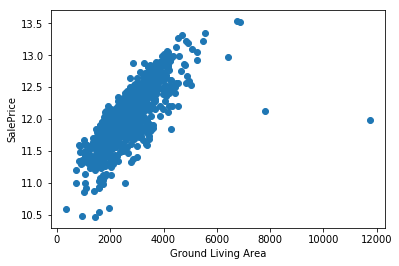

In [16]:
#Plot train ONLY to review SalePrice outliers
train2=comb.loc[0:1459].copy()
plt.scatter(train2.TOT_SF, train2.SalePrice)
plt.xlabel('Ground Living Area')
plt.ylabel('SalePrice')
plt.show()

In [17]:
outliers=train2[train2['TOT_SF']>6900].copy()
outliers.loc[:,['TOT_SF','SalePrice']]

,TOT_SF,SalePrice
523,7814.0,12.126764
1298,11752.0,11.982935


In [18]:
#drop outliers from working data - comb (not train)
comb=comb.drop(index=outliers.index,errors='ignore')
print('comb:', comb.shape)

comb: (2917, 83)


In [19]:
#drop ID - unrelated to SalePrice
comb.drop('Id',axis=1, inplace=True)

In [20]:
#Convert object to category for encoding
for c in comb.columns:
        if comb[c].dtype=='object':
            comb[c]=comb[c].astype('category') 

#Also, convert MSSubClass from Int64 to category            
comb['MSSubClass']=comb['MSSubClass'].astype('category')

In [21]:
#Engineer MoSold
MS_dict={'MoSold': {12: 'Winter',
                  1: 'Winter',
                  2: 'Winter',
                  3: 'Spring',
                  4: 'Spring',
                  5: 'Spring',
                  6: 'Summer',
                  7: 'Summer',
                  8: 'Summer',
                  9: 'Fall',
                  10: 'Fall',
                  11: 'Fall'}}

comb.replace(MS_dict, inplace=True)
comb['MoSold']=comb['MoSold'].astype('category')

In [22]:
#Restore train and test from comb
train_cln=comb.loc[0:1459].copy()
test_cln=comb.loc[1460:].copy()

In [23]:
print('train_cln:',train_cln.shape,'test_cln:',test_cln.shape)
display(train_cln.tail(2))
display(test_cln.head(2))

train_cln: (1458, 82) test_cln: (1459, 82)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod
1458,20,RL,68.0,9717,Pave,None,Reg,0,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,3,3,Mn,3,49.0,2,1029.0,0.0,1078.0,GasA,4,Y,FuseA,1078,0,0,1078,1.0,0.0,1,0,2,1,4,5,7,0,None,Attchd,1,1.0,240.0,3,3,3,366,0,112,0,0,0,None,None,None,0,Spring,2010,WD,Normal,11.864469,2156.0,60,14
1459,20,RL,75.0,9937,Pave,None,Reg,0,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,4,3,CBlock,3,3,No,1,830.0,LwQ,290.0,136.0,1256.0,GasA,4,Y,SBrkr,1256,0,0,1256,1.0,0.0,1,1,3,1,3,6,7,0,None,Attchd,3,1.0,276.0,3,3,3,736,68,0,0,0,0,None,None,None,0,Summer,2008,WD,Normal,11.901590,2512.0,43,43


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod
1460,20,RH,80.0,11622,Pave,None,Reg,0,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,CBlock,3,3,No,2,468.0,LwQ,144.0,270.0,882.0,GasA,3,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,3,5,7,0,None,Attchd,1,1.0,730.0,3,3,3,140,0,0,0,120,0,None,MnPrv,None,0,Summer,2010,WD,Normal,NaN,1778.0,49,49
1461,20,RL,81.0,14267,Pave,None,IR1,0,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,3,3,CBlock,3,3,No,2,923.0,1,0.0,406.0,1329.0,GasA,3,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,4,6,7,0,None,Attchd,1,1.0,312.0,3,3,3,393,36,0,0,0,0,None,None,Gar2,12500,Summer,2010,WD,Normal,NaN,2658.0,52,52


In [24]:
#Min-Max scale numeric features in train.  Apply identical scaling to test.
def scale_train(df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    num_df=df.select_dtypes(include=['int64','float64']).copy()
    num_df.drop('SalePrice', axis=1, inplace=True)
    num_df[num_df.columns]=num_df[num_df.columns].astype('float64')  #convert everything to float for scaler
    scaled_arr=scaler.fit_transform(num_df)   #scaler must have 2D array, not 1D.  Ex. [['col_name']] Series.
    #Keep existing df index - outliers were dropped, removing certain indices.
    num_df=pd.DataFrame(data=scaled_arr,index=df.index,columns=num_df.columns)
    return num_df, scaler  #use fitted scaler to scale test equally

def scale_test(df, scaler_trn):
    num_df=df.select_dtypes(include=['int64','float64']).copy()
    num_df.drop('SalePrice', axis=1, inplace=True)
    num_df[num_df.columns]=num_df[num_df.columns].astype('float64')  #convert everything to float for scaler
    scaled_arr=scaler_trn.transform(num_df)   #scaler is global variable from MinMax_scale_train
    #Keep existing df index - outliers were dropped, removing certain indices.
    num_df=pd.DataFrame(data=scaled_arr,index=df.index,columns=num_df.columns)
    return num_df  #use fitted scaler to scale test equally

# #Fit & scale train
# num_trn_cln, scaler_trn=scale_train(train_cln)
# train_cln[num_trn_cln.columns]=num_trn_cln

# #Scale test equally (using train scaler)
# num_tst_cln=scale_test(test_cln, scaler_trn)
# test_cln[num_tst_cln.columns]=num_tst_cln

In [25]:
print('train_cln:',train_cln.shape,'test_cln:',test_cln.shape)
display(train_cln.head(3))
display(test_cln.head(3))

train_cln: (1458, 82) test_cln: (1459, 82)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod
0,60,RL,65.0,8450,Pave,None,Reg,0,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,No,3,706.0,1,0.0,150.0,856.0,GasA,5,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,7,0,None,Attchd,2,2.0,548.0,3,3,3,0,61,0,0,0,0,None,None,None,0,Winter,2008,WD,Normal,12.247699,2566.0,5,5
1,20,RL,80.0,9600,Pave,None,Reg,0,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,Gd,2,978.0,1,0.0,284.0,1262.0,GasA,5,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,7,1,TA,Attchd,2,2.0,460.0,3,3,3,298,0,0,0,0,0,None,None,None,0,Spring,2007,WD,Normal,12.109016,2524.0,31,31
2,60,RL,68.0,11250,Pave,None,IR1,0,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,Mn,3,486.0,1,0.0,434.0,920.0,GasA,5,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,7,1,TA,Attchd,2,2.0,608.0,3,3,3,0,42,0,0,0,0,None,None,None,0,Fall,2008,WD,Normal,12.317171,2706.0,7,6


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod
1460,20,RH,80.0,11622,Pave,None,Reg,0,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,CBlock,3,3,No,2,468.0,LwQ,144.0,270.0,882.0,GasA,3,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,3,5,7,0,None,Attchd,1,1.0,730.0,3,3,3,140,0,0,0,120,0,None,MnPrv,None,0,Summer,2010,WD,Normal,NaN,1778.0,49,49
1461,20,RL,81.0,14267,Pave,None,IR1,0,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,3,3,CBlock,3,3,No,2,923.0,1,0.0,406.0,1329.0,GasA,3,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,4,6,7,0,None,Attchd,1,1.0,312.0,3,3,3,393,36,0,0,0,0,None,None,Gar2,12500,Summer,2010,WD,Normal,NaN,2658.0,52,52
1462,60,RL,74.0,13830,Pave,None,IR1,0,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4,3,No,3,791.0,1,0.0,137.0,928.0,GasA,4,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,3,6,7,1,TA,Attchd,3,2.0,482.0,3,3,3,212,34,0,0,0,0,None,MnPrv,None,0,Spring,2010,WD,Normal,NaN,2557.0,13,12


In [26]:
#DUMMIES CATEGORICAL ENCODING
train_cln=pd.get_dummies(train_cln)
test_cln=pd.get_dummies(test_cln)

In [27]:
#Keep columns common to train_cln/test_cln only.  
#Ex.  suppose test_clean has category 'pink' missing from train_cln.   Then remove pink one hot column.
train_cln_drops, test_cln_drops=features_unique_to_set(train=train_cln, test=test_cln)
train_cln.drop(columns=train_cln_drops, axis=1, inplace=True, errors='ignore')
test_cln.drop(columns=test_cln_drops, axis=1, inplace=True, errors='ignore')

In [28]:
print('train_cln:',train_cln.shape,'test_cln:',test_cln.shape)
display(train_cln.head(2))
display(test_cln.head(2))

train_cln: (1458, 272) test_cln: (1459, 272)


,LotFrontage,LotArea,LandContour,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_LwQ,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_LwQ,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Fall,MoSold_Spring,MoSold_Summer,MoSold_Winter,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,0,7,5,2003,2003,196.0,4,3,4,3,706.0,0.0,150.0,856.0,5,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,7,0,2,2.0,548.0,3,3,3,0,61,0,0,0,0,0,2008,12.247699,2566.0,5,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,0,6,8,1976,1976,0.0,3,3,4,3,978.0,0.0,284.0,1262.0,5,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,7,1,2,2.0,460.0,3,3,3,298,0,0,0,0,0,0,2007,12.109016,2524.0,31,31,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


,LotFrontage,LotArea,LandContour,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_LwQ,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_LwQ,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Fall,MoSold_Spring,MoSold_Summer,MoSold_Winter,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,80.0,11622,0,5,6,1961,1961,0.0,3,3,3,3,468.0,144.0,270.0,882.0,3,896,0,0,896,0.0,0.0,1,0,2,1,3,5,7,0,1,1.0,730.0,3,3,3,140,0,0,0,120,0,0,2010,NaN,1778.0,49,49,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1461,81.0,14267,0,6,6,1958,1958,108.0,3,3,3,3,923.0,0.0,406.0,1329.0,3,1329,0,0,1329,0.0,0.0,1,1,3,1,4,6,7,0,1,1.0,312.0,3,3,3,393,36,0,0,0,0,12500,2010,NaN,2658.0,52,52,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def train_and_test(what_model, num_folds, dfr):
    counter=1
    rmse_vals=[]
    features=dfr.columns.drop('SalePrice')
    model=what_model
    kf=KFold(n_splits=num_folds, shuffle=True)
    for train_idx, test_idx in kf.split(dfr):
        train=dfr.iloc[train_idx]  #when k=5, 80% of train.csv is train
        test=dfr.iloc[test_idx]    #when k=5, 20% of train.csv is test
        model.fit(train[features], train['SalePrice'])
        test_pred=model.predict(test[features])                   
        rmse=round((mean_squared_error(test['SalePrice'], test_pred))**0.5, 2)
        #print('RMSE -', rmse)
        rmse_vals.append(rmse)
        avg_rmse=np.mean(rmse_vals)
        counter+=1
    return avg_rmse, model

In [30]:
train_x=train_cln.drop('SalePrice', axis=1, errors='ignore')
test_x=test_cln.drop('SalePrice', axis=1, errors='ignore')
train_y=train_cln['SalePrice']
test_y=test_cln['SalePrice']

In [31]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression(fit_intercept=True)
avg_rmse, linMod= train_and_test(what_model=lr, num_folds=5, dfr=train_cln)
print('AvgRMSE:', round(avg_rmse,5), '\n')
print('LR R^2:', round(lr.score(train_x, train_y),3))

AvgRMSE: 0.128 

LR R^2: 0.937


In [32]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=1.0)
avg_rmse, lassMod= train_and_test(what_model=lasso, num_folds=5, dfr=train_cln)
print('AvgRMSE:', round(avg_rmse,5), '\n')
print('lasso R^2:', round(lasso.score(train_x, train_y),3))

AvgRMSE: 0.17 

lasso R^2: 0.824


In [33]:
from sklearn.linear_model import Ridge #BEST LEARNER
ridge=Ridge(alpha=1)
avg_rmse, ridgeMod= train_and_test(what_model=ridge, num_folds=50, dfr=train_cln)
print('AvgRMSE:', round(avg_rmse,5), '\n')
print('ridge R^2:', round(ridgeMod.score(train_x, train_y),3))

AvgRMSE: 0.1126 

ridge R^2: 0.945


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

#Grid search code for RandomForestRegressor
features=train_cln.columns.drop('SalePrice')
ftrain_x, ftest_x, ftrain_y, ftest_y = train_test_split(train_cln[features], train_cln['SalePrice'],\
                                   test_size=0.25,random_state=42)

rfr=RandomForestRegressor(oob_score=False)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 20)]
max_features = ['log2', 'sqrt']
max_depth = [5,10,15,20,25,40,80]
min_samples_split = [2,4,6,8,10,12,15,17,20]
min_samples_leaf = [2,4,5,6,8,10,15,20]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

model_random=RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter=80, n_jobs=-1,\
                                random_state=42, cv=2, return_train_score=True)
model_random.fit(ftrain_x, ftrain_y)

test_pred=model_random.predict(ftrain_x)
rmse=round((mean_squared_error(ftrain_y, test_pred))**0.5, 2)
print('RMSE of ftrain:', rmse)
print(model_random.best_estimator_)
print('rfr R^2:', round(model_random.score(ftrain_x, ftrain_y),3))

RMSE of ftrain: 0.08
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=468, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
rfr R^2: 0.959


In [35]:
#Predict and inverse normalize prediction
test_pred=ridgeMod.predict(test_x)
test_pred=np.exp(test_pred)-1
print('test_pred len:', len(test_pred))
test_pred[0:4]

test_pred len: 1459


array([121799.12362259, 157034.39397263, 181848.01704414, 200811.4570156 ])

In [36]:
#Kaggle Submission -
submission_df=pd.DataFrame({'Id':test['Id'], 'SalePrice':test_pred})
#submission_df.to_csv('submissions/submission011519_22.csv', index=False)

In [37]:
test_cln.tail()

,LotFrontage,LotArea,LandContour,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_LwQ,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_LwQ,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Fall,MoSold_Spring,MoSold_Summer,MoSold_Winter,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
2914,21.0,1936,0,4,7,1970,1970,0.0,3,3,3,3,0.0,0.0,546.0,546.0,4,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,7,0,2,0.0,0.0,0,0,3,0,0,0,0,0,0,0,2006,NaN,1638.0,36,36,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2915,21.0,1894,0,4,5,1970,1970,0.0,3,3,3,3,252.0,0.0,294.0,546.0,3,546,546,0,1092,0.0,0.0,1,1,3,1,3,6,7,0,1,1.0,286.0,3,3,3,0,24,0,0,0,0,0,2006,NaN,1638.0,36,36,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2916,160.0,20000,0,5,7,1960,1996,0.0,3,3,3,3,1224.0,0.0,0.0,1224.0,5,1224,0,0,1224,1.0,0.0,1,0,4,1,3,7,7,1,1,2.0,576.0,3,3,3,4

In [38]:
#Export comb to train & test csv files.
# train_cln=comb.loc[0:1459].copy()
# test_cln=comb.loc[1460:2918].copy()
# test_cln=test_cln.drop('SalePrice', axis=1, errors='ignore')
# train_cln.to_csv('data/train_cln.csv', index=True)
# test_cln.to_csv('data/test_cln.csv', index=True)

#Script to fix index in new notebook.
# trn=pd.read_csv('data/train_cln.csv')
# trn=trn.set_index('Unnamed: 0')
# del trn.index.name

# tst=pd.read_csv('data/test_cln.csv',index_col=None)
# tst=tst.set_index('Unnamed: 0')
# del tst.index.name

In [39]:
#Remove low scoring numeric features
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression   #scoring for regression
# from sklearn.feature_selection import chi2    #scoring for classificiation
# from operator import itemgetter

# drop_num_cols=KBest_drop_numeric(df=comb.loc[0:1459],drop_frac=0.1)  #use train data ONLY to avoid leakage
# ctr=1
# for c in drop_num_cols:
#     comb=comb.drop(c, axis=1, errors='ignore')
#     print('Drop', ctr, ':',c)
#     ctr+=1
# print('After KBest low score feature drop:', comb.loc[0:1459].shape)